In [1]:
# This notebook loads in the monthly IGRA data and identifies tropical stations
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import xarray as xr
from scipy import interpolate as interp
import warnings
warnings.simplefilter("ignore")

In [2]:
# Constants
Lv0 = 2.501E6 #J/kg
cpd = 1005.7 #J/kg/K
cpv = 1870 #J/kg/K
cl = 4190 #J/kg/K assuming temperatures higher than 0C
g = 9.806 #m/s^2
a = 6.37E6 #m

a1 = 611.21 #Pa
a3 = 17.502
a4 = 32.19 #K
T0 = 273.16 #K
Rd = 287.0597 #J/kg/K
Rv = 461.5250 #J/kg/K
p0 = 100000 #Pa

2788 512
             id  latitude  longitude  elevation state  \
1   AEM00041217   24.4333    54.6500       16.0   NaN   
6   AFM00040948   34.5500    69.2167     1791.0   NaN   
7   AFM00040990   31.5000    65.8500     1010.0   NaN   
25  AGM00060571   31.5000    -2.2500      811.0   NaN   
33  AGM00060630   27.2333     2.5000      273.0   NaN   

                              name  fstyear  lstyear   nobs  
1   ABU DHABI INTERNATIONAL AIRPOR     1983     2019  36329  
6                    KABUL AIRPORT     1961     2019  17887  
7                 KANDAHAR AIRPORT     1976     2014   5934  
25                          BECHAR     1948     2019  57990  
33                        IN-SALAH     1964     2019  48682  


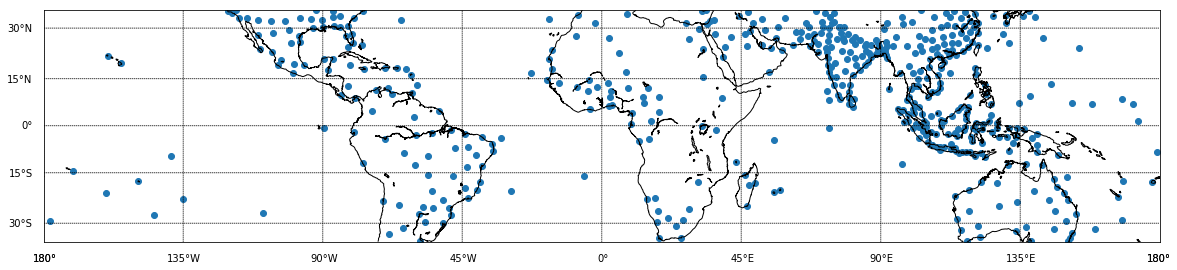

In [3]:
# Load in the station list
file = 'igra2-station-list.txt'
col_names = ['id', 'latitude', 'longitude', 'elevation', 'state', 
             'name', 'fstyear', 'lstyear', 'nobs']
stations = pd.read_fwf(file, widths=[11,9,10,7,4,31,4,5,7], header=None, names=col_names)

# Select stations between 35S and 35N with data between 1997 and 2014
lat_min = -35
lat_max = 35
year_min = 1997
year_max = 2014
valid_stations = stations[(stations.latitude >= lat_min) & (stations.latitude <= lat_max)]
valid_stations = valid_stations[(valid_stations.lstyear >= year_max) & 
                                (valid_stations.fstyear <= year_min)]
nstations_orig = np.size(stations,0)
nstations = np.size(valid_stations,0)
print(nstations_orig, nstations)
print(valid_stations.head())

data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y)

In [11]:
# Load in the station data
file = 'monthly_data/vwnd_12z-mly.txt'
col_names = ['id', 'year', 'month', 'level', 'value', 'num']
data = pd.read_fwf(file, widths=[11,5,3,5,7,3], header=None, names=col_names)

# Select the stations within the latitude and year ranges
year_min = 1997
year_max = 2014
i = 0
ind = valid_stations.index[i]
temp = data[data.id == valid_stations.id[ind]]
temp = temp[(temp.year <= year_max) & (temp.year >= year_min)]
data_validstations = temp
for i in np.arange(nstations-1):
    print((i+1)/nstations)
    ind = valid_stations.index[i+1]
    temp = data[data.id == valid_stations.id[ind]]
    temp = temp[(temp.year <= year_max) & (temp.year >= year_min)]
    data_validstations = data_validstations.append(temp)

# Create climatologies for each station
levels = [9999, 1000, 925, 850, 700, 500, 400, 300, 250,
          200, 150, 100, 70, 50, 30, 20, 10, 7, 5, 3]
nlevels = np.size(levels)
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
i = 0
j = 0
k = 0
ind = valid_stations.index[i]
temp = data_validstations[data_validstations.id == valid_stations.id[ind]]
temp = temp[temp.month == months[j]]
temp = temp[temp.level == levels[k]]
vals = {'month': months[j],
        'level': levels[k],
        'value': temp.value.mean(),
        'nyears': np.size(temp.value, 0),
        'nobs': temp.num.sum()}
data_validstations_clim = pd.DataFrame(vals, index=[valid_stations.id[ind]])
for i in np.arange(nstations):
    print(i/nstations)
    ind = valid_stations.index[i]
    temp = data_validstations[data_validstations.id == valid_stations.id[ind]]
    for j in np.arange(12):
        temp2 = temp[temp.month == months[j]]
        for k in np.arange(nlevels):
            temp3 = temp2[temp2.level == levels[k]]
            vals = {'month': months[j],
                    'level': levels[k],
                    'value': temp3.value.mean(),
                    'nyears': np.size(temp3.value, 0),
                    'nobs': temp3.num.sum()}
            temp4 = pd.DataFrame(vals, index=[valid_stations.id[ind]])
            data_validstations_clim = data_validstations_clim.append(temp4)
data_validstations_clim = data_validstations_clim[1:]
data_validstations_clim.head()

0.001953125
0.00390625
0.005859375
0.0078125
0.009765625
0.01171875
0.013671875


KeyboardInterrupt: 

In [30]:
# Save station climatologies
data_validstations_clim.to_csv('monthly_clim/vwnd_12z-clim.csv', sep='\t')

In [4]:
# Load in saved climatologies
temp_00z_clim = pd.read_csv('monthly_clim/temp_00z-clim.csv', sep='\t', index_col=0)
temp_12z_clim = pd.read_csv('monthly_clim/temp_12z-clim.csv', sep='\t', index_col=0)
vapr_00z_clim = pd.read_csv('monthly_clim/vapr_00z-clim.csv', sep='\t', index_col=0)
vapr_12z_clim = pd.read_csv('monthly_clim/vapr_12z-clim.csv', sep='\t', index_col=0)
ghgt_00z_clim = pd.read_csv('monthly_clim/ghgt_00z-clim.csv', sep='\t', index_col=0)
ghgt_12z_clim = pd.read_csv('monthly_clim/ghgt_12z-clim.csv', sep='\t', index_col=0)
uwnd_00z_clim = pd.read_csv('monthly_clim/uwnd_00z-clim.csv', sep='\t', index_col=0)
uwnd_12z_clim = pd.read_csv('monthly_clim/uwnd_12z-clim.csv', sep='\t', index_col=0)
vwnd_00z_clim = pd.read_csv('monthly_clim/vwnd_00z-clim.csv', sep='\t', index_col=0)
vwnd_12z_clim = pd.read_csv('monthly_clim/vwnd_12z-clim.csv', sep='\t', index_col=0)

In [ ]:
# To calculate station equivalent potential temperatures, I need surface pressure from somewhere.
# Load in ERA-Interim surface pressures and interpolate onto the latitudes of the
# valid stations
year_start = 1997
year_end = 2014
nyears = year_end - year_start + 1
i = 0
j = 0
k = 0
f = xr.open_dataset('../era_interim/monthly/surface/'+str(i+year_start)+'.nc')
lat_era = np.array(f.latitude[:])
lon_era = np.array(f.longitude[:])
nlat_era = np.size(lat_era, 0)
nlon_era = np.size(lon_era, 0)
ps_era = np.array(f.sp[:])
f.close()
# Move longitudes 180-360 to -180-0
lon2_era = np.roll(lon_era,int(nlon_era/2))
lon2_era[0:int(nlon_era/2)] = lon2_era[0:int(nlon_era/2)] - 360
ps2_era = np.roll(ps_era,int(nlon_era/2), axis=2)
ind = valid_stations.index[j]
lat_sta = valid_stations.latitude[ind]
lon_sta = valid_stations.longitude[ind]
f = interp.interp2d(lon2_era, lat_era, ps2_era[k,:,:], kind = 'linear')
ps_sta = f(lon_sta, lat_sta)
vals = {'year': year_min+i,
        'month': k+1,
        'value': ps_sta}
ps_validstations = pd.DataFrame(vals, index=[valid_stations.id[ind]])
for i in np.arange(nyears):
    print(i/nyears)
    f = xr.open_dataset('../era_interim/monthly/surface/'+str(i+year_start)+'.nc')
    ps_era = np.array(f.sp[:])
    ps2_era = np.roll(ps_era,int(nlon_era/2), axis=2)
    for j in np.arange(nstations):
        ind = valid_stations.index[j]
        lat_sta = valid_stations.latitude[ind]
        lon_sta = valid_stations.longitude[ind]
        for k in np.arange(12):
            f = interp.interp2d(lon2_era, lat_era, ps2_era[k,:,:], kind = 'linear')
            ps_sta = f(lon_sta, lat_sta)
            vals = {'year': year_min+i,
                    'month': k+1,
                    'value': ps_sta}
            temp = pd.DataFrame(vals, index=[valid_stations.id[ind]])
            ps_validstations = ps_validstations.append(temp)
ps_validstations = ps_validstations[1:]
# Save the station surface pressure
ps_validstations.to_csv('era_interim_interpolated_to_stations/ps_monthly_erainterim.csv', sep='\t')
ps_validstations.head()

In [5]:
# Calculate ERA Interim surface pressure climatology at station locations and save it
ps_validstations = pd.read_csv('era_interim_interpolated_to_stations/ps_monthly_erainterim.csv', sep='\t', index_col=0)
i = 0
j = 0
ind = valid_stations.index[i]
temp = ps_validstations[ps_validstations.index == valid_stations.id[ind]]
temp = temp[temp.month == j+1]
vals = {'month': j+1,
        'value': temp.value.mean()}
ps_validstations_clim = pd.DataFrame(vals, index=[valid_stations.id[ind]])
for i in np.arange(nstations):
    #print(i/nstations)
    ind = valid_stations.index[i]
    temp = ps_validstations[ps_validstations.index == valid_stations.id[ind]]
    for j in np.arange(12):
        temp2 = temp[temp.month == j+1]
        vals = {'month': j+1,
                'value': temp2.value.mean()}
        temp3 = pd.DataFrame(vals, index=[valid_stations.id[ind]])
        ps_validstations_clim = ps_validstations_clim.append(temp3)
ps_validstations_clim = ps_validstations_clim[1:]
ps_validstations_clim.to_csv('era_interim_interpolated_to_stations/ps_monthly_clim_erainterim.csv', sep='\t')
ps_validstations_clim.head()

month          value
AEM00041217      1  100994.968030
AEM00041217      2  100790.448280
AEM00041217      3  100510.202156
AEM00041217      4  100166.219991
AEM00041217      5   99694.532858

In [8]:
# Calculate station equivalent potential temperatures
# Do a simple nanmean of the 00z and 12z values, ignoring differences in coverage
nrows = np.size(temp_00z_clim,0)
temp = np.ndarray(shape=(nrows,2), dtype='float')
temp[:,0] = np.array(temp_00z_clim.value.copy())
temp[:,1] = np.array(temp_12z_clim.value.copy())
temp = np.nanmean(273.15 + temp/10, axis=1)
T_dailymean = temp_00z_clim.copy()
T_dailymean.value = temp

temp = np.ndarray(shape=(nrows,2), dtype='float')
temp[:,0] = np.array(vapr_00z_clim.value.copy())
temp[:,1] = np.array(vapr_12z_clim.value.copy())
temp = np.nanmean(temp/10, axis=1)
e = temp
r_dailymean = vapr_00z_clim.copy()
r_dailymean.value = temp
r_dailymean.value = (Rd/Rv)*(r_dailymean.value/(100*r_dailymean.level-r_dailymean.value))

# Calculate equivalent and saturated equivalent potentential temperature
T = np.array(T_dailymean.value.copy())
r = np.array(r_dailymean.value.copy())
rt = r
es = a1*np.exp(a3*((T - T0)/(T - a4)))
rs = np.array((Rd/Rv)*es/(100*r_dailymean.level.copy()-es))
H = e/es
pdry = np.array(100*r_dailymean.level.copy() - e)
Lv = Lv0 + (cpv - cl)*(T - 273.16)
th_e_dailymean = T_dailymean.copy()
th_e_dailymean.value = T*(p0/pdry)**(Rd/(cpd + cl*rt))*H**(-r*Rv/(cpd + cl*rt))*np.exp(Lv*r/(T*(cpd + cl*rt)))
th_es_dailymean = T_dailymean.copy()
th_es_dailymean.value = T*(p0/pdry)**(Rd/(cpd + cl*rs))*np.exp(Lv*rs/(T*(cpd + cl*rs)))

# Calculate those quantities for the surface, using surface pressures from ERA Interim
ps_clim = pd.read_csv('era_interim_interpolated_to_stations/ps_monthly_clim_erainterim.csv', sep='\t', index_col=0)
T = np.array(T_dailymean[T_dailymean.level==9999].value.copy())
nrows2 = np.size(T,0)
temp = np.ndarray(shape=(nrows2,2), dtype='float')
temp[:,0] = np.array(vapr_00z_clim[vapr_00z_clim.level==9999].value.copy())
temp[:,1] = np.array(vapr_12z_clim[vapr_12z_clim.level==9999].value.copy())
e = np.nanmean(temp/10, axis=1)
es = a1*np.exp(a3*((T - T0)/(T - a4)))
r = (Rd/Rv)*e/(np.array(ps_clim.value.copy())-e)
rt = r
rs = np.array((Rd/Rv)*es/(ps_clim.value.copy()-es))
H = e/es
pdry = np.array(ps_clim.value.copy() - e)
Lv = Lv0 + (cpv - cl)*(T - 273.16)
th_e_dailymean.value[th_e_dailymean.level==9999] = T*(p0/pdry)**(Rd/(cpd + cl*rt))*H**(-r*Rv/(cpd + cl*rt))*np.exp(Lv*r/(T*(cpd + cl*rt)))
th_es_dailymean.value[th_es_dailymean.level==9999] = T*(p0/pdry)**(Rd/(cpd + cl*rs))*np.exp(Lv*rs/(T*(cpd + cl*rs)))

# Calculate the average saturated equivalent potential temperature for the upper
# troposphere
levels = [9999, 1000, 925, 850, 700, 500, 400, 300, 250,
          200, 150, 100, 70, 50, 30, 20, 10, 7, 5, 3]
nlevels = np.size(levels)
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dp = [0, 75, 75, 112.5, 175, 150, 100, 75, 50, 50, 50, 
      40, 25, 20, 15, 10, 6.5, 2.5, 2, 4]
i = 0
j = 0
ind = valid_stations.index[i]
temp = th_es_dailymean[th_es_dailymean.index == valid_stations.id[ind]].copy()
temp = temp[temp.month == months[j]]
temp.value = temp.value*dp
temp = temp[temp.level >= 200]
temp = temp[temp.level <= 400]
factor = np.array(temp.value)
factor = factor/factor
vals = {'month': months[j],
        'value': temp.value.sum()/np.nansum(factor*dp[6:10])}
th_es_uppertrop = pd.DataFrame(vals, index=[valid_stations.id[ind]])
for i in np.arange(nstations):
    print(i/nstations)
    ind = valid_stations.index[i]
    temp = th_es_dailymean[th_es_dailymean.index == valid_stations.id[ind]].copy()
    for j in np.arange(12):
        temp2 = temp[temp.month == months[j]]
        temp2.value = temp2.value*dp
        temp2 = temp2[temp2.level >= 200]
        temp2 = temp2[temp2.level <= 400]
        factor = np.array(temp2.value)
        factor = factor/factor
        vals = {'month': months[j],
                'value': temp2.value.sum()/np.nansum(factor*dp[6:10])}
        temp3 = pd.DataFrame(vals, index=[valid_stations.id[ind]])
        th_es_uppertrop = th_es_uppertrop.append(temp3)
th_es_uppertrop = th_es_uppertrop[1:]

0.0
0.001953125
0.00390625
0.005859375
0.0078125
0.009765625
0.01171875
0.013671875
0.015625
0.017578125
0.01953125
0.021484375
0.0234375
0.025390625
0.02734375
0.029296875
0.03125
0.033203125
0.03515625
0.037109375
0.0390625
0.041015625
0.04296875
0.044921875
0.046875
0.048828125
0.05078125
0.052734375
0.0546875
0.056640625
0.05859375
0.060546875
0.0625
0.064453125
0.06640625
0.068359375
0.0703125
0.072265625
0.07421875
0.076171875
0.078125
0.080078125
0.08203125
0.083984375
0.0859375
0.087890625
0.08984375
0.091796875
0.09375
0.095703125
0.09765625
0.099609375
0.1015625
0.103515625
0.10546875
0.107421875
0.109375
0.111328125
0.11328125
0.115234375
0.1171875
0.119140625
0.12109375
0.123046875
0.125
0.126953125
0.12890625
0.130859375
0.1328125
0.134765625
0.13671875
0.138671875
0.140625
0.142578125
0.14453125
0.146484375
0.1484375
0.150390625
0.15234375
0.154296875
0.15625
0.158203125
0.16015625
0.162109375
0.1640625
0.166015625
0.16796875
0.169921875
0.171875
0.173828125
0.17578125
0.

In [13]:
# Save station equivalent potential temperatures
th_e_dailymean.to_csv('th_e_dailymean.csv', sep='\t')
th_es_dailymean.to_csv('th_es_dailymean.csv', sep='\t')
th_es_uppertrop.to_csv('th_es_uppertrop.csv', sep='\t')

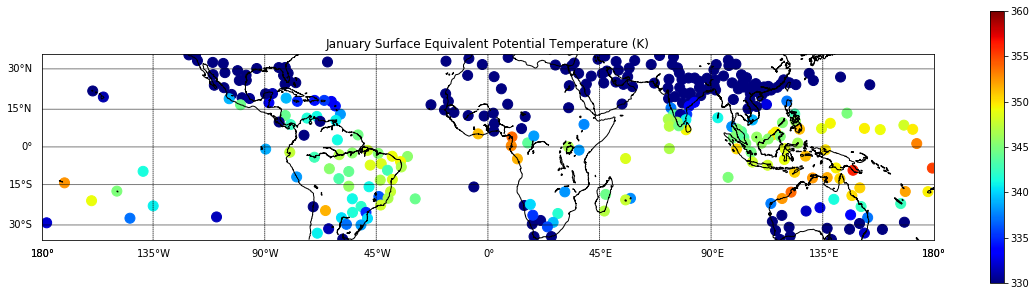

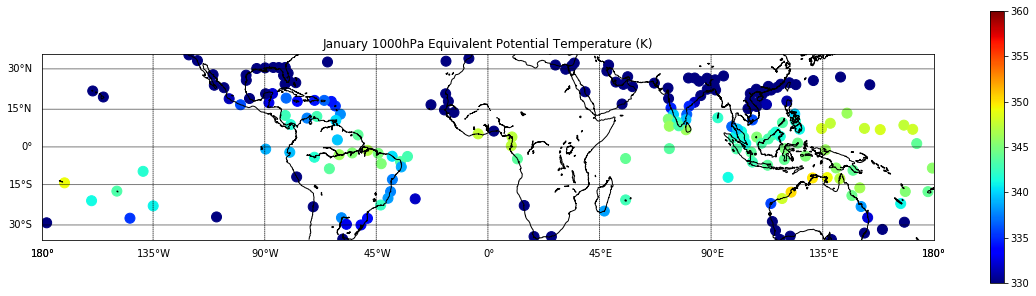

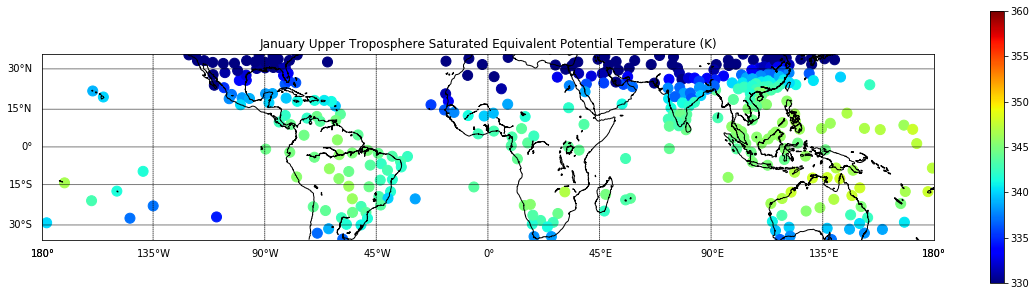

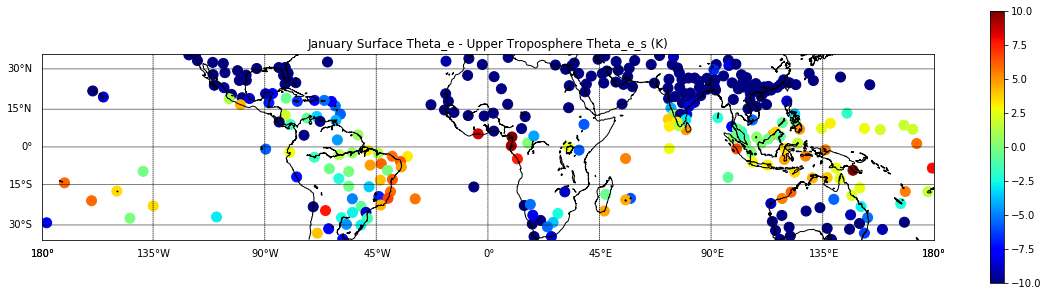

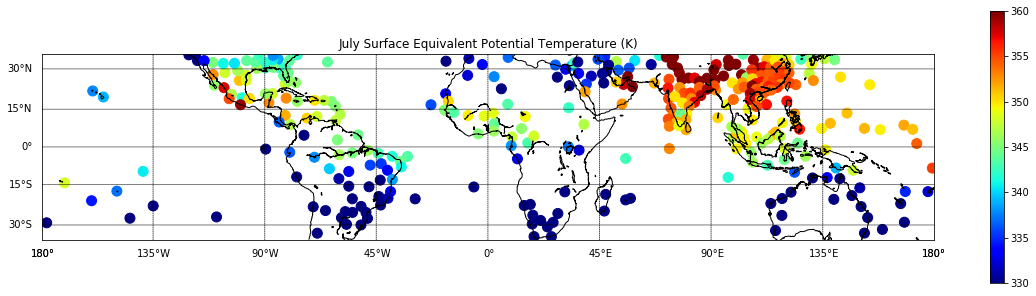

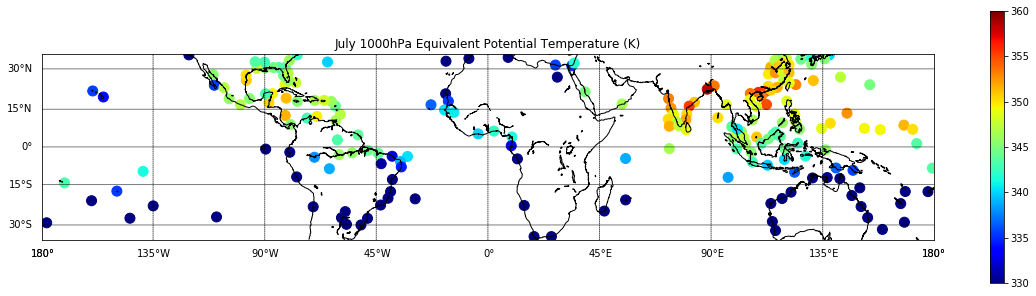

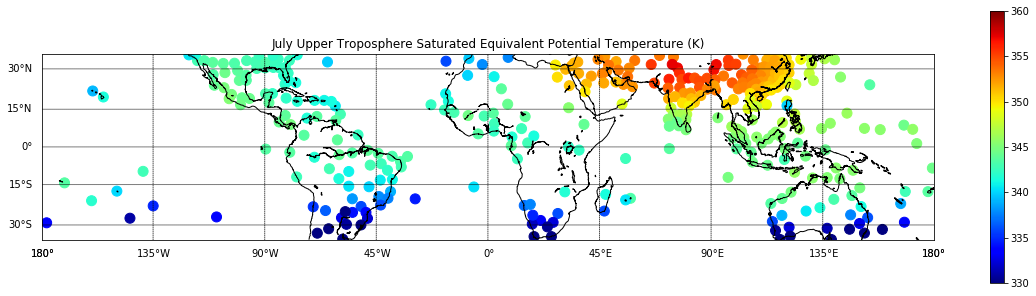

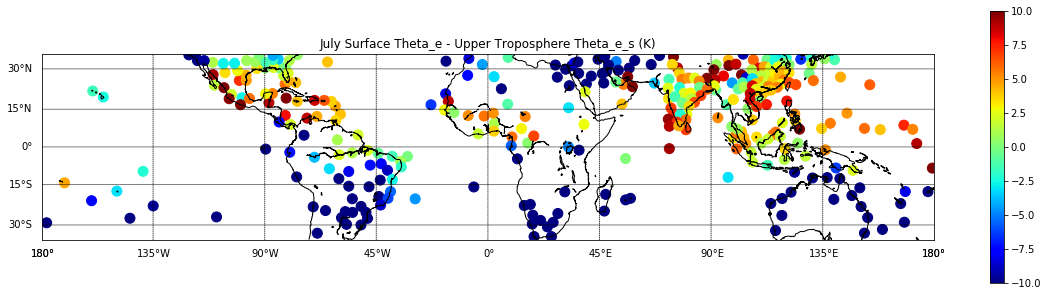

In [4]:
# Plot values at the surface, 1000hPa, and upper troposphere average
th_e_dailymean = pd.read_csv('th_e_dailymean.csv', sep='\t', index_col=0)
th_es_dailymean = pd.read_csv('th_es_dailymean.csv', sep='\t', index_col=0)
th_es_uppertrop = pd.read_csv('th_es_uppertrop.csv', sep='\t', index_col=0)

data = th_e_dailymean[th_e_dailymean.level==9999]
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('January Surface Equivalent Potential Temperature (K)')
plt.colorbar();

data = th_e_dailymean[th_e_dailymean.level==1000]
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('January 1000hPa Equivalent Potential Temperature (K)')
plt.colorbar();

data = th_es_uppertrop
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('January Upper Troposphere Saturated Equivalent Potential Temperature (K)')
plt.colorbar();

data1 = th_e_dailymean[th_e_dailymean.level==9999]
data1 = data1[data1.month==1]
data1 = np.array(data1.value)
data1[data1<300] = np.nan
data2 = th_es_uppertrop
data2 = data2[data2.month==1]
data2 = np.array(data2.value)
data2[data2<300] = np.nan
data = data1 - data2
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('January Surface Theta_e - Upper Troposphere Theta_e_s (K)')
plt.colorbar();

data = th_e_dailymean[th_e_dailymean.level==9999]
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,s=100,c=data,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('July Surface Equivalent Potential Temperature (K)')
plt.colorbar();

data = th_e_dailymean[th_e_dailymean.level==1000]
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,s=100,c=data,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('July 1000hPa Equivalent Potential Temperature (K)')
plt.colorbar();

data = th_es_uppertrop
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('July Upper Troposphere Saturated Equivalent Potential Temperature (K)')
plt.colorbar();

data1 = th_e_dailymean[th_e_dailymean.level==9999]
data1 = data1[data1.month==7]
data1 = np.array(data1.value)
data1[data1<300] = np.nan
data2 = th_es_uppertrop
data2 = data2[data2.month==7]
data2 = np.array(data2.value)
data2[data2<300] = np.nan
data = data1 - data2
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('July Surface Theta_e - Upper Troposphere Theta_e_s (K)')
plt.colorbar();

In [4]:
# Load in ERA Interim surface air pressure, 2m air temperature, and 2m dew point
# temperature and calculate surface equivalent potential temperatures
year_start = 1997
nyears = 18
years = np.arange(0,nyears) + year_start
month = ['January','February','March','April','May','June',
        'July','August','September','October','November','December']
ps = np.ndarray(shape=(nyears,12,241,480), dtype = float)
t = np.ndarray(shape=(nyears,12,241,480), dtype = float)
td = np.ndarray(shape=(nyears,12,241,480), dtype = float)

# Load variables and replace fillvalues with nans
# Switch to using xr.open_dataset?
for i in np.arange(nyears):
    f = xr.open_dataset('../era_interim/monthly/surface/'+str(i+year_start)+'.nc')
    ps[i,:,:,:] = np.array(f.variables['sp'][:])
    t[i,:,:,:] = np.array(f.variables['t2m'][:])
    td[i,:,:,:] = np.array(f.variables['d2m'][:])
    f.close()

f = xr.open_dataset('../era_interim/monthly/surface/'+str(i+year_start)+'.nc')
lat_era = np.array(f.variables['latitude'][:])
lon_era = np.array(f.variables['longitude'][:])
f.close()

t0 = T0
es_t = a1*np.exp(a3*((t - t0)/(t - a4)))
es_td = a1*np.exp(a3*((td - t0)/(td - a4)))
H = es_td/es_t
q = (Rd/Rv)*es_td/(ps - (1 - Rd/Rv)*es_td)
r = (Rd/Rv)*es_td/(ps - es_td)
Lv = Lv0 + (cpv - cl)*(t - t0)
pdry = ps - es_td
rt = r
th_e_sfc = t*(p0/pdry)**(Rd/(cpd + cl*rt))*H**(-r*Rv/(cpd + cl*rt))*np.exp(Lv*r/(t*(cpd + cl*rt)))
th_e_sfc_clim = np.nanmean(th_e_sfc, axis=0)

In [5]:
# Calculate the upper troposphere mean equivalent potential temperatures,
# for now ignoring liquid water to enable a better comparison to station data
year_start = 1997
nyears = 18
years = np.arange(0,nyears) + year_start
months = ['January','February','March','April','May','June',
        'July','August','September','October','November','December']

# Grid (P-level horizontal grid is different than model level grid)
f = xr.open_dataset('../era_interim/monthly/p_level/temperature/temperature_1997.nc')
lat_plevel = np.array(f.latitude)
lon_plevel = np.array(f.longitude)
level = np.array(f.level) # units of mb
nlat = np.size(lat_plevel,0)
nlon = np.size(lon_plevel,0)
nlevel = np.size(level,0)

# Vertical grid: define the levels and dP between them for the
# vertical average over the upper troposphere
levelstart_upper = 14 # 14: 200mb
levelend_upper = 19 # 19: 400mb
levelface = np.ndarray(shape=(nlevel+1), dtype = float)
levelface[0] = 0
levelface[1:-1] = 0.5*(level[:-1] + level[1:])
levelface[nlevel] = 1.5*level[nlevel-1] - 0.5*level[nlevel-2]
dp = levelface[1:] - levelface[:-1]

# Initialize arrays
th_estar_uppertrop = np.ndarray(shape=(nyears,12,nlat,nlon), dtype = float)
th_e_uppertrop = np.ndarray(shape=(nyears,12,nlat,nlon), dtype = float)
H_uppertrop = np.ndarray(shape=(nyears,12,nlat,nlon), dtype = float)
dp_temp = np.tile(dp,(12,nlon,nlat,1))
dp_temp = np.swapaxes(dp_temp,1,3)
p_temp = np.tile(level,(12,nlon,nlat,1))
p_temp = np.swapaxes(p_temp,1,3)

for i in np.arange(nyears):
    print(years[i])
    f = xr.open_dataset('../era_interim/monthly/p_level/temperature/temperature_'
                        +str(i+year_start)+'.nc')
    T = np.array(f.t)
    f.close()
    f = xr.open_dataset('../era_interim/monthly/p_level/specific_humidity/q_'
                        +str(i+year_start)+'.nc')
    q = np.array(f.q)
    f.close()
    #f = xr.open_dataset('../era_interim/monthly/p_level/cloud_liquid_water/clwc_'
    #                    +str(i+year_start)+'.nc')
    #clwc = np.array(f.clwc)
    #f.close()
    #f = xr.open_dataset('../era_interim/monthly/p_level/cloud_fraction/cc_'
    #                    +str(i+year_start)+'.nc')
    #cc = np.array(f.cc)
    #f.close()
    
    # Calculate saturation vapor pressure
    estar = (a1/100)*np.exp(a3*((T - T0)/(T - a4))) # in mb
    
    # Mixing ratio from Emanuel (1994)
    #ql = clwc*cc
    rstar = (Rd/Rv)*estar/(p_temp - estar)
    r = q/(1 - q)
    rt = r
    #rl = ql/(1 - ql)
    #rt = r + rl
    
    # Relative humidity from Emanuel (1994) eq. 4.1.4, 4.1.5
    e = r*p_temp/((Rd/Rv) + r)
    H = e/estar
    
    # Saturation equivalent potential temperature from Emanuel (1994) eq. 4.5.11
    # and 4.4.4
    # Notes: the saturated mixing ratio is equal to the vapor mixing ratio, and the
    # relative humidity is equal to one for that calculation.
    pdry = p_temp - estar
    Lv = Lv0 + (cpv - cl)*(T - T0)
    th_estar = T*(p0/(100*pdry))**(Rd/(cpd + cl*rstar))*np.exp(Lv*rstar/(T*(cpd + cl*rstar)))
    th_e = T*(p0/(100*pdry))**(Rd/(cpd + cl*rt))*H**(-r*Rv/(cpd + cl*rt))*np.exp(Lv*r/(T*(cpd + cl*rt)))
    
    # Take the vertical average over the upper and middle troposphere
    temp = th_estar*dp_temp
    th_estar_uppertrop[i,:,:,:] = np.sum(temp[:,levelstart_upper:levelend_upper,:,:],
                                         axis = 1)/np.sum(dp_temp[:,levelstart_upper:levelend_upper,:,:], axis = 1)
    temp = th_e*dp_temp
    th_e_uppertrop[i,:,:,:] = np.sum(temp[:,levelstart_upper:levelend_upper,:,:],
                                     axis = 1)/np.sum(dp_temp[:,levelstart_upper:levelend_upper,:,:], axis = 1)
    temp = H*dp_temp
    H_uppertrop[i,:,:,:] = np.sum(temp[:,levelstart_upper:levelend_upper,:,:],
                                  axis = 1)/np.sum(dp_temp[:,levelstart_upper:levelend_upper,:,:], axis = 1)

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [6]:
# Interpolate the upper troposphere values onto the surface lat/lon,
# under the assumption that the upper troposphere values are smoother
# and their intrpolation will be more accurate
th_estar_uppertrop_interp = np.ndarray(shape = (nyears,12,nlat,nlon), dtype = 'float')
th_e_uppertrop_interp = np.ndarray(shape = (nyears,12,nlat,nlon), dtype = 'float')
for i in np.arange(nyears):
    for j in np.arange(12):
        f = interp.interp2d(lon_plevel, -lat_plevel, th_estar_uppertrop[i,j,:,:], kind = 'cubic')
        th_estar_uppertrop_interp[i,j,:,:] = f(lon_era, lat_era)
        f = interp.interp2d(lon_plevel, -lat_plevel, th_e_uppertrop[i,j,:,:], kind = 'cubic')
        th_e_uppertrop_interp[i,j,:,:] = f(lon_era, lat_era)

# Calculate climatologies
th_estar_UT_clim = np.mean(th_estar_uppertrop, axis=0)
th_e_UT_clim = np.mean(th_e_uppertrop, axis=0)
th_estar_UT_interp_clim = np.mean(th_estar_uppertrop_interp, axis=0)
th_e_UT_interp_clim = np.mean(th_e_uppertrop_interp, axis=0)

In [7]:
# Save the reanalysis calculations
lat_era_plevel = lat_plevel
lon_era_plevel = lon_plevel
th_estar_UT_clim = xr.DataArray(th_estar_UT_clim, dims=['month','lat_era_plevel','lon_era_plevel'],
                                coords={'month': months,
                                        'lat_era_plevel': lat_era_plevel,
                                        'lon_era_plevel': lon_era_plevel})
th_e_UT_clim = xr.DataArray(th_e_UT_clim, dims=['month','lat_era_plevel','lon_era_plevel'],
                            coords={'month': months,
                                    'lat_era_plevel': lat_era_plevel,
                                    'lon_era_plevel': lon_era_plevel})
th_estar_UT_interp_clim = xr.DataArray(th_estar_UT_interp_clim, dims=['month','lat_era','lon_era'],
                                       coords={'month': months,
                                               'lat_era': lat_era,
                                               'lon_era': lon_era})
th_e_UT_interp_clim = xr.DataArray(th_e_UT_interp_clim, dims=['month','lat_era','lon_era'],
                                   coords={'month': months,
                                           'lat_era': lat_era,
                                           'lon_era': lon_era})
th_e_sfc_clim = xr.DataArray(th_e_sfc_clim, dims=['month','lat_era','lon_era'],
                             coords={'month': months,
                                     'lat_era': lat_era,
                                     'lon_era': lon_era})

era_th_e_clim = xr.Dataset(
        data_vars={'th_estar_UT_clim': (('month', 'lat_era_plevel', 'lon_era_plevel'), th_estar_UT_clim),
                   'th_e_UT_clim': (('month', 'lat_era_plevel', 'lon_era_plevel'), th_e_UT_clim),
                   'th_estar_UT_interp_clim': (('month', 'lat_era', 'lon_era'), th_estar_UT_interp_clim),
                   'th_e_UT_interp_clim': (('month', 'lat_era', 'lon_era'), th_e_UT_interp_clim),
                   'th_e_sfc_clim': (('month', 'lat_era', 'lon_era'), th_e_sfc_clim)},
        coords={'month': months,
                'lat_era': lat_era,
                'lon_era': lon_era,
                'lat_era_plevel': lat_era_plevel,
                'lon_era_plevel': lon_era_plevel})
xr.Dataset.to_netcdf(era_th_e_clim, 'era_interim_clim/era_th_e_clim.nc', mode='w', format = 'NETCDF4')

In [8]:
# Load in the station data, the reanalysis data and interpolate the reanalysis onto station lat/lon
# Station data:
th_e_dailymean = pd.read_csv('th_e_dailymean.csv', sep='\t', index_col=0)
th_es_dailymean = pd.read_csv('th_es_dailymean.csv', sep='\t', index_col=0)
th_es_uppertrop = pd.read_csv('th_es_uppertrop.csv', sep='\t', index_col=0)

# Reanalysis data:
f = xr.open_dataset('era_interim_clim/era_th_e_clim.nc')
lat_era = np.array(f.lat_era[:])
lon_era = np.array(f.lon_era[:])
lat_era_plevel = np.array(f.lat_era_plevel[:])
lon_era_plevel = np.array(f.lon_era_plevel[:])
th_estar_UT_clim = np.array(f.th_estar_UT_clim[:]) # (lat,lon)_era_plevel
th_e_sfc_clim = np.array(f.th_e_sfc_clim[:]) #(lat,lon)_era
nlat_era = np.size(lat_era, 0)
nlon_era = np.size(lon_era, 0)
nlat_era_plevel = np.size(lat_era_plevel, 0)
nlon_era_plevel = np.size(lon_era_plevel, 0)

# Interpolate reanalysis onto station locations
year_start = 1997
year_end = 2014
nyears = year_end - year_start + 1
j = 0
k = 0
# Move longitudes 180-360 to -180-0
lon2_era = np.roll(lon_era,int(nlon_era/2))
lon2_era[0:int(nlon_era/2)] = lon2_era[0:int(nlon_era/2)] - 360
lon2_era_plevel = np.roll(lon_era_plevel,int(nlon_era_plevel/2))
lon2_era_plevel[0:int(nlon_era_plevel/2)] = lon2_era_plevel[0:int(nlon_era_plevel/2)] - 360
# Move data to the new longitudes
th_e_sfc_clim2 = np.roll(th_e_sfc_clim,int(nlon_era/2), axis=2)
th_estar_UT_clim2 = np.roll(th_estar_UT_clim,int(nlon_era_plevel/2), axis=2)
# Do the interpolation, station-by-station
ind = valid_stations.index[j]
lat_sta = valid_stations.latitude[ind]
lon_sta = valid_stations.longitude[ind]
f = interp.interp2d(lon2_era, lat_era, th_e_sfc_clim2[k,:,:], kind = 'linear')
th_e_interp = f(lon_sta, lat_sta)
vals = {'month': k+1,
        'value': th_e_interp}
th_e_sfc_sta = pd.DataFrame(vals, index=[valid_stations.id[ind]])
f = interp.interp2d(lon2_era_plevel, lat_era_plevel, th_estar_UT_clim2[k,:,:], kind = 'linear')
th_estar_interp = f(lon_sta, lat_sta)
vals = {'month': k+1,
        'value': th_estar_interp}
th_estar_UT_sta = pd.DataFrame(vals, index=[valid_stations.id[ind]])
for j in np.arange(nstations):
    print(j/nstations)
    ind = valid_stations.index[j]
    lat_sta = valid_stations.latitude[ind]
    lon_sta = valid_stations.longitude[ind]
    for k in np.arange(12):
        f = interp.interp2d(lon2_era, lat_era, th_e_sfc_clim2[k,:,:], kind = 'linear')
        th_e_interp = f(lon_sta, lat_sta)
        vals = {'month': k+1,
                'value': th_e_interp}
        temp = pd.DataFrame(vals, index=[valid_stations.id[ind]])
        th_e_sfc_sta = th_e_sfc_sta.append(temp)
        f = interp.interp2d(lon2_era_plevel, lat_era_plevel, th_estar_UT_clim2[k,:,:], kind = 'linear')
        th_estar_interp = f(lon_sta, lat_sta)
        vals = {'month': k+1,
                'value': th_estar_interp}
        temp = pd.DataFrame(vals, index=[valid_stations.id[ind]])
        th_estar_UT_sta = th_estar_UT_sta.append(temp)
th_e_sfc_sta = th_e_sfc_sta[1:]
th_estar_UT_sta = th_estar_UT_sta[1:]
# Save the station surface pressure
th_e_sfc_sta.to_csv('era_interim_interpolated_to_stations/th_e_sfc_sta.csv', sep='\t')
th_estar_UT_sta.to_csv('era_interim_interpolated_to_stations/th_estar_UT_sta.csv', sep='\t')
th_estar_UT_sta.head()

0.0
0.001953125
0.00390625
0.005859375
0.0078125
0.009765625
0.01171875
0.013671875
0.015625
0.017578125
0.01953125
0.021484375
0.0234375
0.025390625
0.02734375
0.029296875
0.03125
0.033203125
0.03515625
0.037109375
0.0390625
0.041015625
0.04296875
0.044921875
0.046875
0.048828125
0.05078125
0.052734375
0.0546875
0.056640625
0.05859375
0.060546875
0.0625
0.064453125
0.06640625
0.068359375
0.0703125
0.072265625
0.07421875
0.076171875
0.078125
0.080078125
0.08203125
0.083984375
0.0859375
0.087890625
0.08984375
0.091796875
0.09375
0.095703125
0.09765625
0.099609375
0.1015625
0.103515625
0.10546875
0.107421875
0.109375
0.111328125
0.11328125
0.115234375
0.1171875
0.119140625
0.12109375
0.123046875
0.125
0.126953125
0.12890625
0.130859375
0.1328125
0.134765625
0.13671875
0.138671875
0.140625
0.142578125
0.14453125
0.146484375
0.1484375
0.150390625
0.15234375
0.154296875
0.15625
0.158203125
0.16015625
0.162109375
0.1640625
0.166015625
0.16796875
0.169921875
0.171875
0.173828125
0.17578125
0.

NameError: name 'ps_validstations' is not defined

In [4]:
# Load in station data, era-interim reanalysis, and reanalysis interpolated onto
# station locations
# Station data:
th_e_dailymean = pd.read_csv('th_e_dailymean.csv', sep='\t', index_col=0)
th_es_dailymean = pd.read_csv('th_es_dailymean.csv', sep='\t', index_col=0)
th_es_uppertrop = pd.read_csv('th_es_uppertrop.csv', sep='\t', index_col=0)

# Reanalysis data:
f = xr.open_dataset('era_interim_clim/era_th_e_clim.nc')
lat_era = np.array(f.lat_era[:])
lon_era = np.array(f.lon_era[:])
lat_era_plevel = np.array(f.lat_era_plevel[:])
lon_era_plevel = np.array(f.lon_era_plevel[:])
th_estar_UT_clim = np.array(f.th_estar_UT_clim[:]) # (lat,lon)_era_plevel
th_estar_UT_interp_clim = np.array(f.th_estar_UT_clim[:]) # (lat,lon)_era
th_e_sfc_clim = np.array(f.th_e_sfc_clim[:]) #(lat,lon)_era
nlat_era = np.size(lat_era, 0)
nlon_era = np.size(lon_era, 0)
nlat_era_plevel = np.size(lat_era_plevel, 0)
nlon_era_plevel = np.size(lon_era_plevel, 0)

# Reanalysis at station locations:
th_e_sfc_sta = pd.read_csv('era_interim_interpolated_to_stations/th_e_sfc_sta.csv', sep='\t', index_col=0)
th_estar_UT_sta = pd.read_csv('era_interim_interpolated_to_stations/th_estar_UT_sta.csv', sep='\t', index_col=0)

0.7231652644057652 0.8085458326922235


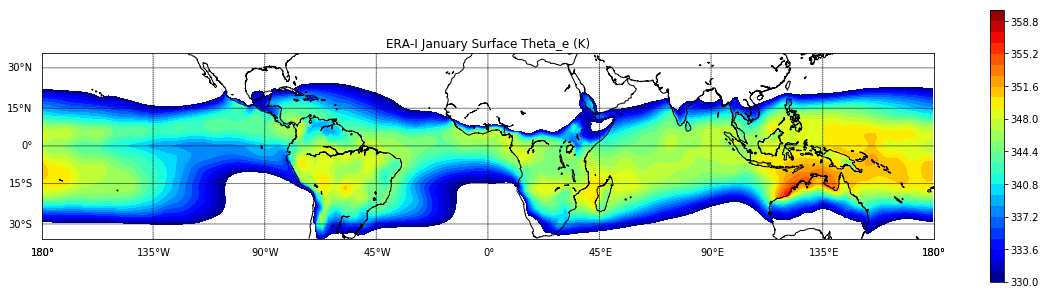

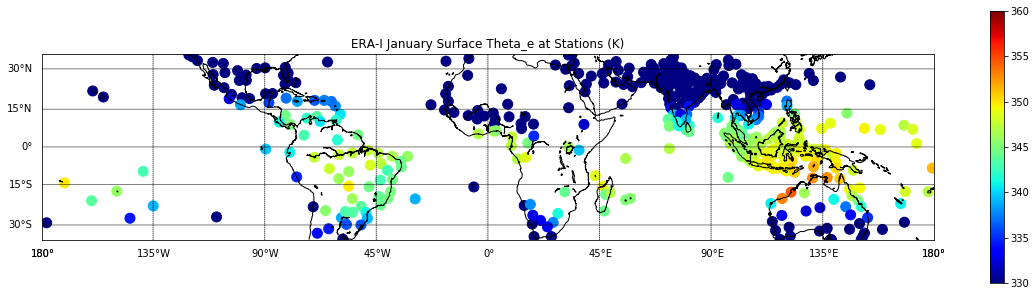

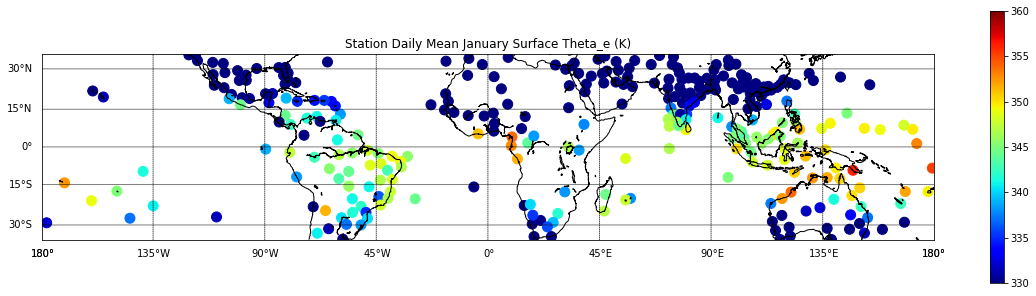

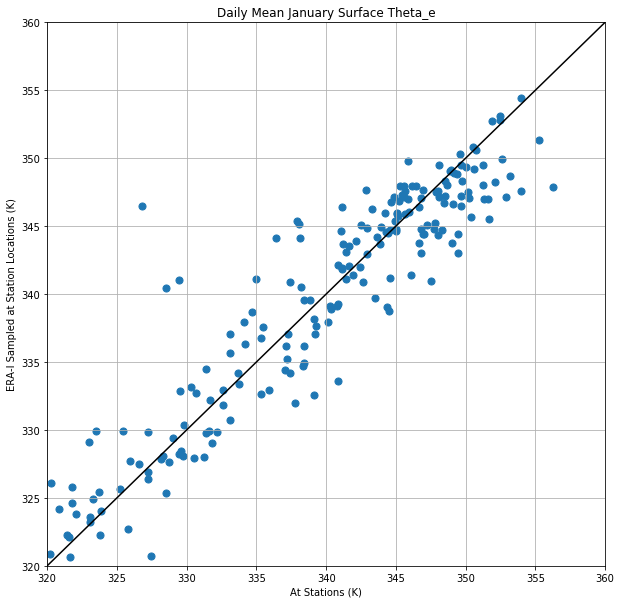

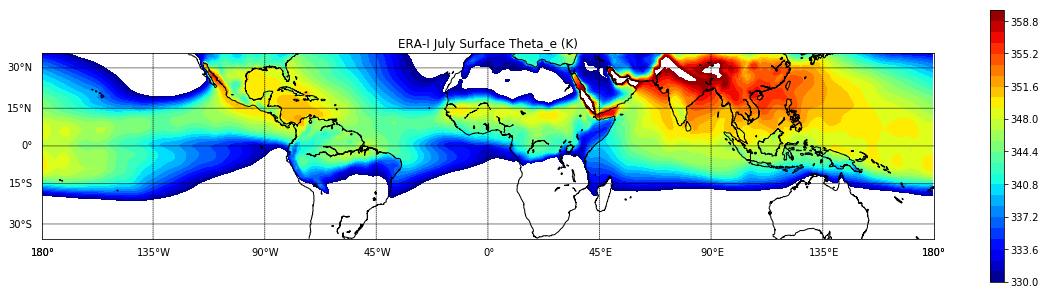

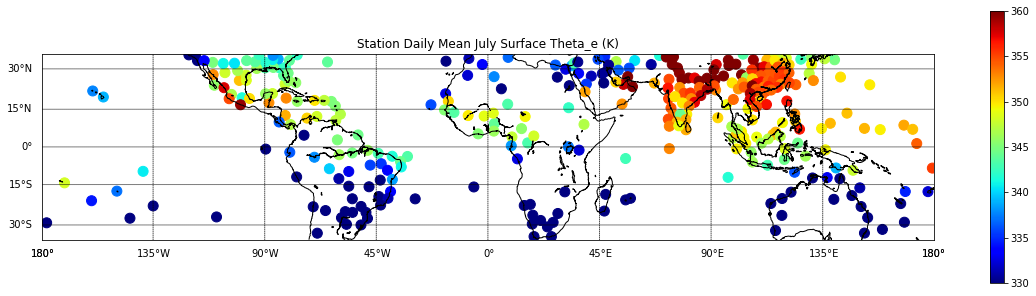

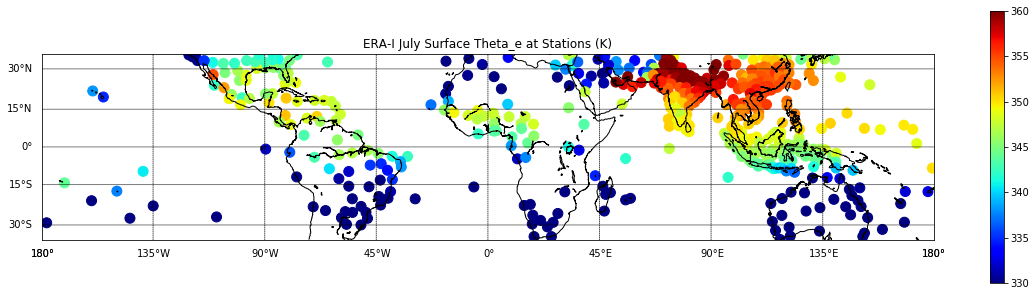

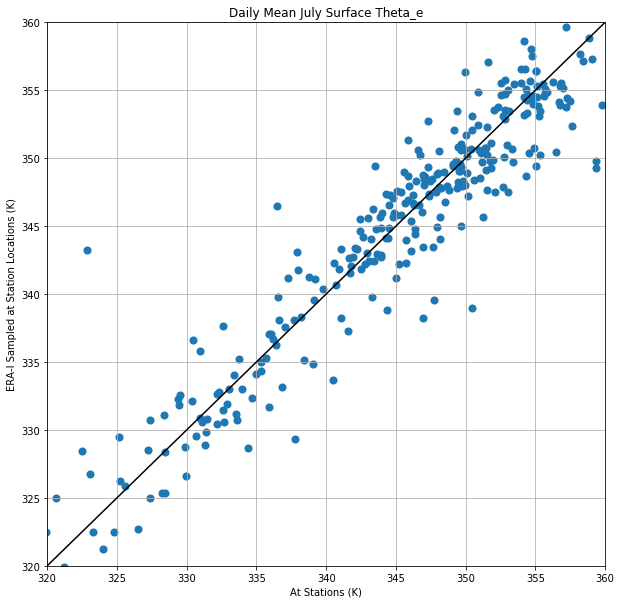

In [54]:
# Plot January and July surface theta_e
nlon_era = np.size(lon_era, 0)
lon2_era = np.roll(lon_era,int(nlon_era/2))
lon2_era[0:int(nlon_era/2)] = lon2_era[0:int(nlon_era/2)] - 360

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era,lat_era))
data = np.squeeze(th_e_sfc_clim[0,:,:])
data = np.roll(data,int(nlon_era/2), axis=1)
v = np.linspace(330, 360, 26, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I January Surface Theta_e (K)')
plt.colorbar();

data = th_e_sfc_sta
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('ERA-I January Surface Theta_e at Stations (K)')
plt.colorbar();

data = th_e_dailymean[th_e_dailymean.level==9999]
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('Station Daily Mean January Surface Theta_e (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax = th_e_dailymean[th_e_dailymean.level==9999]
datax = datax[datax.month==1]
datax = np.array(datax.value)
datay = th_e_sfc_sta
datay = datay[datay.month==1]
datay = np.array(datay.value)
x = datax[datax>340]
y = datay[datax>340]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jan = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([300, 360], [300, 360], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(320, 360)
plt.ylim(320, 360)
plt.title('Daily Mean January Surface Theta_e')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era,lat_era))
data = np.squeeze(th_e_sfc_clim[6,:,:])
data = np.roll(data,int(nlon_era/2), axis=1)
v = np.linspace(330, 360, 26, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I July Surface Theta_e (K)')
plt.colorbar();

data = th_e_dailymean[th_e_dailymean.level==9999]
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,s=100,c=data,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('Station Daily Mean July Surface Theta_e (K)')
plt.colorbar();

data = th_e_sfc_sta
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(330, 360)
plt.title('ERA-I July Surface Theta_e at Stations (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax = th_e_dailymean[th_e_dailymean.level==9999]
datax = datax[datax.month==7]
datax = np.array(datax.value)
datay = th_e_sfc_sta
datay = datay[datay.month==7]
datay = np.array(datay.value)
x = datax[datax>340]
y = datay[datax>340]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jul = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([300, 360], [300, 360], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(320, 360)
plt.ylim(320, 360)
plt.title('Daily Mean July Surface Theta_e')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

print(r_jan, r_jul)

0.920892829935363 0.9851652861718876


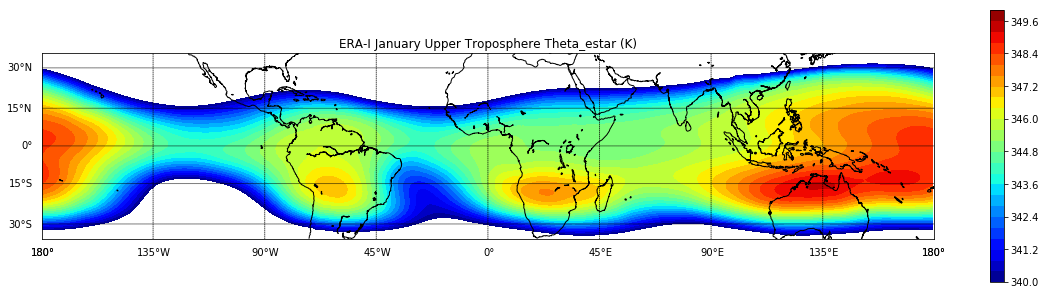

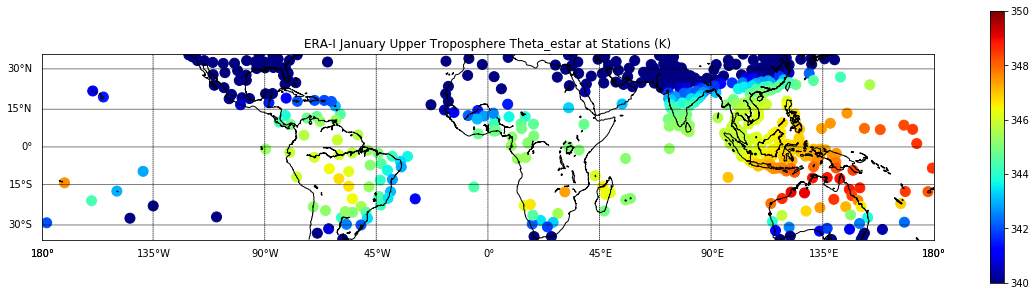

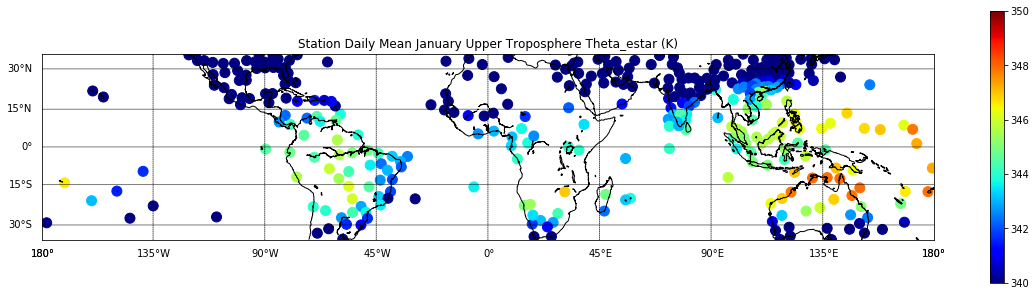

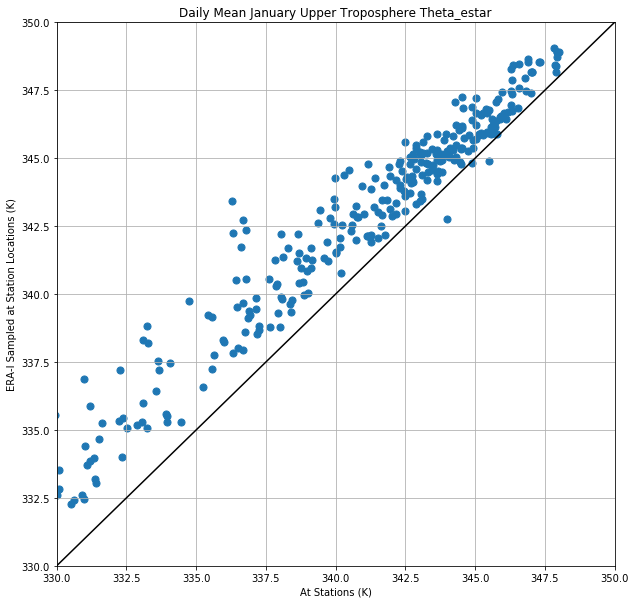

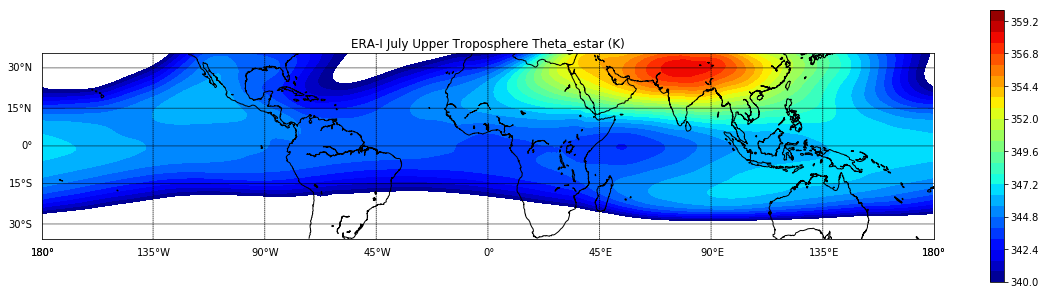

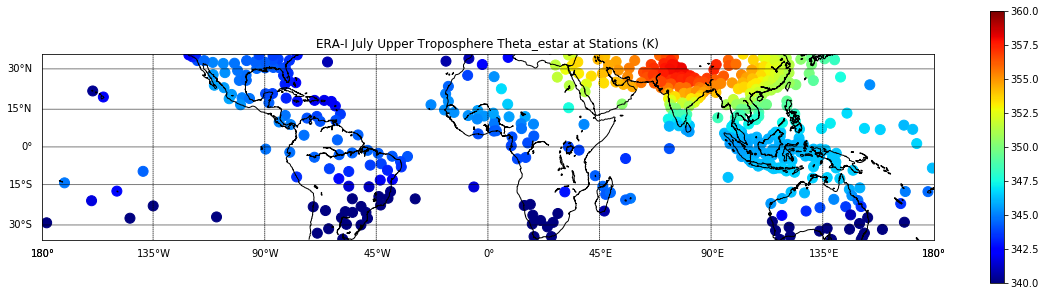

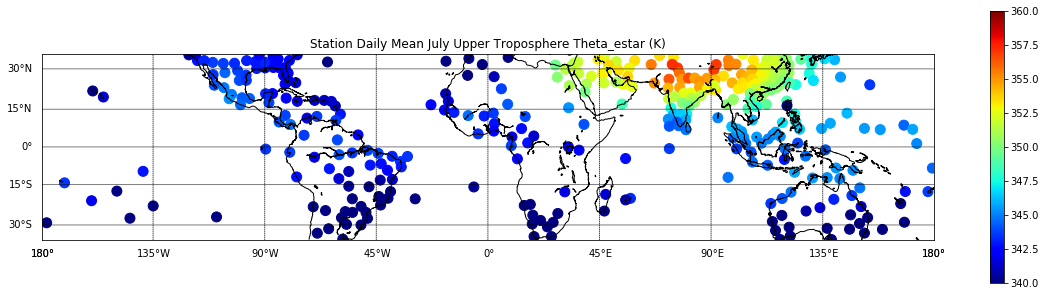

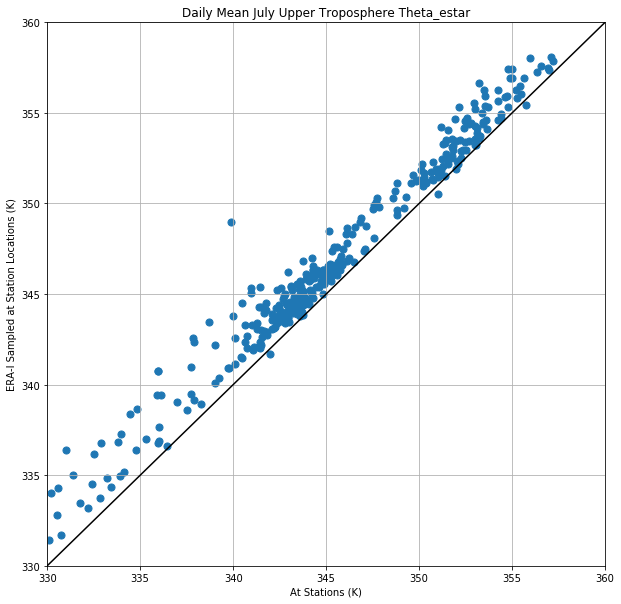

In [55]:
# Plot January and July upper troposphere theta_estar
nlon_era_plevel = np.size(lon_era_plevel, 0)
lon2_era_plevel = np.roll(lon_era_plevel,int(nlon_era_plevel/2))
lon2_era_plevel[0:int(nlon_era_plevel/2)] = lon2_era_plevel[0:int(nlon_era_plevel/2)] - 360

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era_plevel,lat_era_plevel))
data = np.squeeze(th_estar_UT_clim[0,:,:])
data = np.roll(data,int(nlon_era_plevel/2), axis=1)
v = np.linspace(340, 350, 26, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I January Upper Troposphere Theta_estar (K)')
plt.colorbar();

data = th_estar_UT_sta
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(340, 350)
plt.title('ERA-I January Upper Troposphere Theta_estar at Stations (K)')
plt.colorbar();

data = th_es_uppertrop
data = data[data.month==1]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(340, 350)
plt.title('Station Daily Mean January Upper Troposphere Theta_estar (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax = th_es_uppertrop
datax = datax[datax.month==1]
datax = np.array(datax.value)
datay = th_estar_UT_sta
datay = datay[datay.month==1]
datay = np.array(datay.value)
x = datax[datax>340]
y = datay[datax>340]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jan = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([330, 360], [330, 360], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(330, 350)
plt.ylim(330, 350)
plt.title('Daily Mean January Upper Troposphere Theta_estar')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era_plevel,lat_era_plevel))
data = np.squeeze(th_estar_UT_clim[6,:,:])
data = np.roll(data,int(nlon_era_plevel/2), axis=1)
v = np.linspace(340, 360, 26, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I July Upper Troposphere Theta_estar (K)')
plt.colorbar();

data = th_estar_UT_sta
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(340, 360)
plt.title('ERA-I July Upper Troposphere Theta_estar at Stations (K)')
plt.colorbar();

data = th_es_uppertrop
data = data[data.month==7]
data = np.array(data.value)
data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(340, 360)
plt.title('Station Daily Mean July Upper Troposphere Theta_estar (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax = th_es_uppertrop
datax = datax[datax.month==7]
datax = np.array(datax.value)
datay = th_estar_UT_sta
datay = datay[datay.month==7]
datay = np.array(datay.value)
x = datax[datax>340]
y = datay[datax>340]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jul = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([330, 360], [330, 360], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(330, 360)
plt.ylim(330, 360)
plt.title('Daily Mean July Upper Troposphere Theta_estar')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

print(r_jan, r_jul)

0.5874983550591051 0.5190443289293336


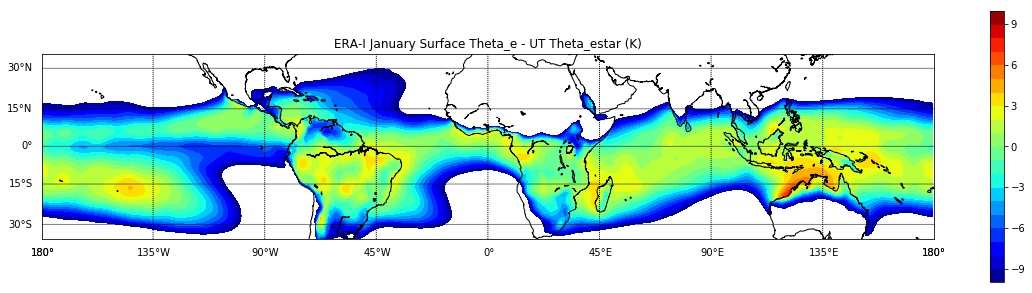

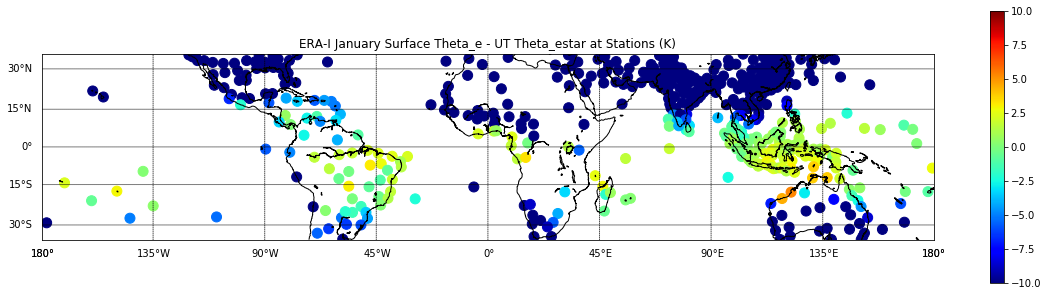

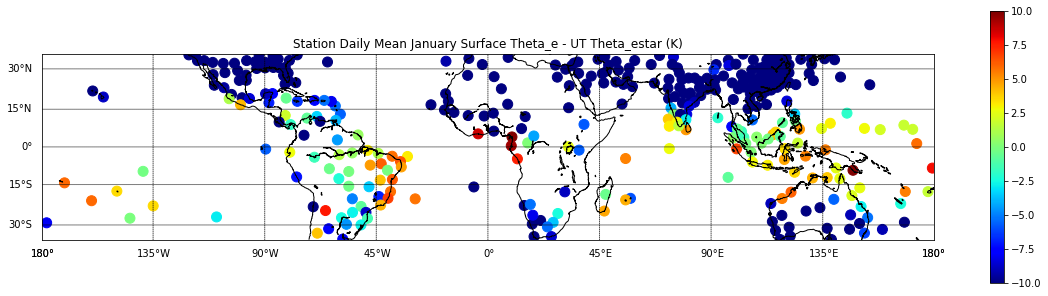

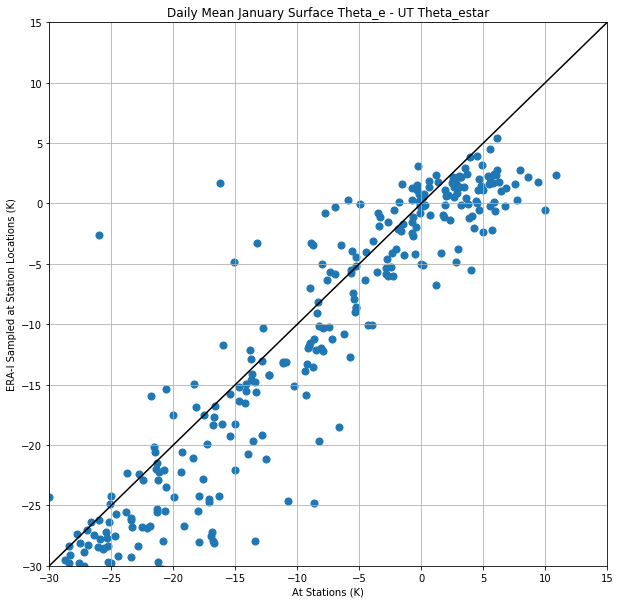

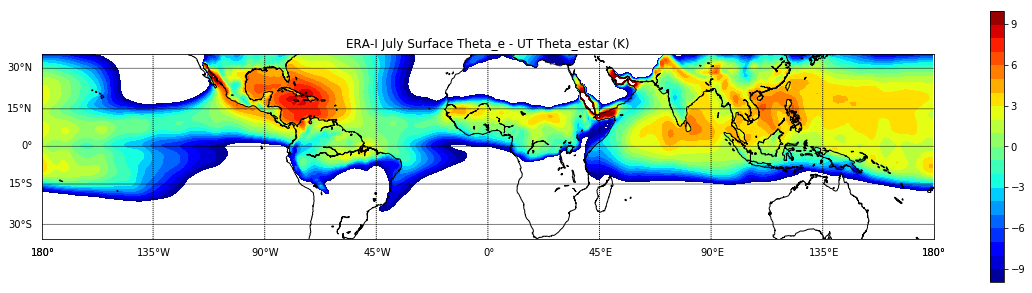

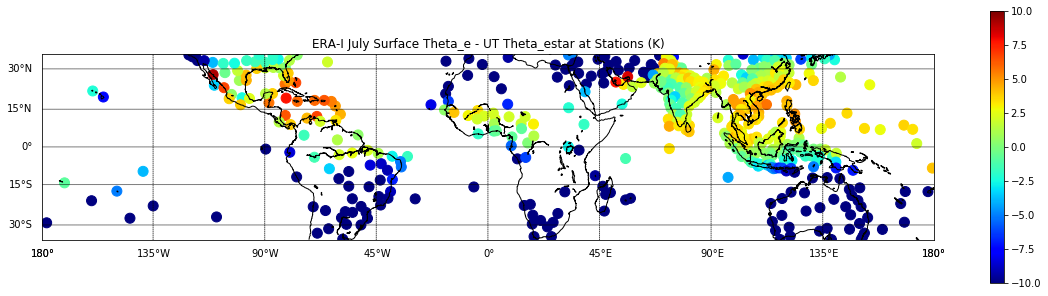

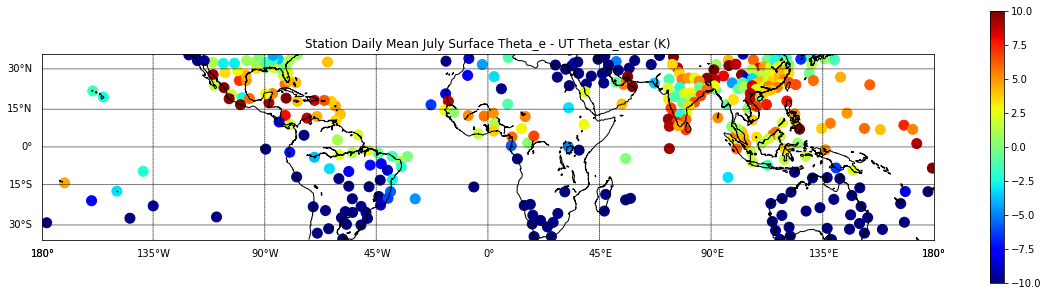

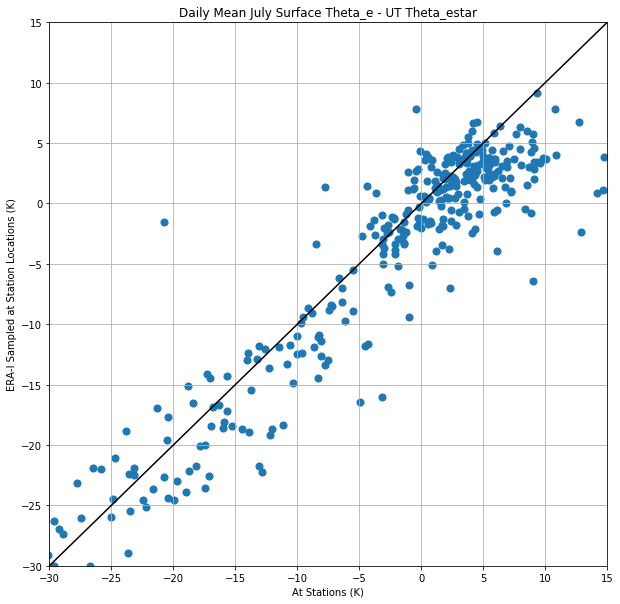

In [53]:
# Plot January and July surface theta_e - upper troposphere theta_estar
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era,lat_era))
data = np.squeeze(th_e_sfc_clim[0,:,:]-th_estar_UT_interp_clim[0,:,:])
data = np.roll(data,int(nlon_era/2), axis=1)
v = np.linspace(-10, 10, 21, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I January Surface Theta_e - UT Theta_estar (K)')
plt.colorbar();

data1 = th_e_sfc_sta
data1 = data1[data1.month==1]
data1 = np.array(data1.value)
data2 = th_estar_UT_sta
data2 = data2[data2.month==1]
data2 = np.array(data2.value)
data = data1-data2
#data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('ERA-I January Surface Theta_e - UT Theta_estar at Stations (K)')
plt.colorbar();

data1 = th_e_dailymean[th_e_dailymean.level==9999]
data1 = data1[data1.month==1]
data1 = np.array(data1.value)
data2 = th_es_uppertrop
data2 = data2[data2.month==1]
data2 = np.array(data2.value)
data = data1-data2
#data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('Station Daily Mean January Surface Theta_e - UT Theta_estar (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax1 = th_e_dailymean[th_e_dailymean.level==9999]
datax1 = datax1[datax1.month==1]
datax1 = np.array(datax1.value)
datax2 = th_es_uppertrop
datax2 = datax2[datax2.month==1]
datax2 = np.array(datax2.value)
datay1 = th_e_sfc_sta
datay1 = datay1[datay1.month==1]
datay1 = np.array(datay1.value)
datay2 = th_estar_UT_sta
datay2 = datay2[datay2.month==1]
datay2 = np.array(datay2.value)
datax = datax1-datax2
datay = datay1-datay2
x = datax[datax>-5]
y = datay[datax>-5]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jan = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([-100, 100], [-100, 100], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(-30, 15)
plt.ylim(-30, 15)
plt.title('Daily Mean January Surface Theta_e - UT Theta_estar')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(*np.meshgrid(lon2_era,lat_era))
data = np.squeeze(th_e_sfc_clim[6,:,:]-th_estar_UT_interp_clim[6,:,:])
data = np.roll(data,int(nlon_era/2), axis=1)
v = np.linspace(-10, 10, 21, endpoint=True)
cs = m.contourf(x,y,data,v,cmap=plt.cm.get_cmap('jet'))
plt.title('ERA-I July Surface Theta_e - UT Theta_estar (K)')
plt.colorbar();

data1 = th_e_sfc_sta
data1 = data1[data1.month==7]
data1 = np.array(data1.value)
data2 = th_estar_UT_sta
data2 = data2[data2.month==7]
data2 = np.array(data2.value)
data = data1-data2
#data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('ERA-I July Surface Theta_e - UT Theta_estar at Stations (K)')
plt.colorbar();

data1 = th_e_dailymean[th_e_dailymean.level==9999]
data1 = data1[data1.month==7]
data1 = np.array(data1.value)
data2 = th_es_uppertrop
data2 = data2[data2.month==7]
data2 = np.array(data2.value)
data = data1-data2
#data[data<300] = np.nan
data_lon = np.array(valid_stations.longitude)
data_lat = np.array(valid_stations.latitude)
fig = plt.figure(num=None, figsize=(20, 5) )
m = Basemap(llcrnrlon=-180.,llcrnrlat=-35,urcrnrlon=180.,urcrnrlat=35.,\
            resolution='l',projection='merc')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,91.,15.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181.,45.),labels=[0,0,0,1])
x, y = m(data_lon,data_lat)
cs = m.scatter(x,y,c=data,s=100,cmap=plt.cm.get_cmap('jet'))
plt.clim(-10, 10)
plt.title('Station Daily Mean July Surface Theta_e - UT Theta_estar (K)')
plt.colorbar();

fig = plt.figure(num=None, figsize=(10, 10))
datax1 = th_e_dailymean[th_e_dailymean.level==9999]
datax1 = datax1[datax1.month==7]
datax1 = np.array(datax1.value)
datax2 = th_es_uppertrop
datax2 = datax2[datax2.month==7]
datax2 = np.array(datax2.value)
datay1 = th_e_sfc_sta
datay1 = datay1[datay1.month==7]
datay1 = np.array(datay1.value)
datay2 = th_estar_UT_sta
datay2 = datay2[datay2.month==7]
datay2 = np.array(datay2.value)
datax = datax1-datax2
datay = datay1-datay2
x = datax[datax>-5]
y = datay[datax>-5]
factorx = x/x
factory = y/y
x = x*factorx*factory
y = y*factorx*factory
x = x - np.nanmean(x)
y = y - np.nanmean(y)
r_jul = np.nanmean(x*y)/(np.nanstd(x)*np.nanstd(y))
plt.plot([-100, 100], [-100, 100], 'k')
plt.scatter(datax, datay, s=50)
plt.grid()
plt.xlim(-30, 15)
plt.ylim(-30, 15)
plt.title('Daily Mean July Surface Theta_e - UT Theta_estar')
plt.xlabel('At Stations (K)')
plt.ylabel('ERA-I Sampled at Station Locations (K)');

print(r_jan, r_jul)